In [1]:
# Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML & DL
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [8]:
import os


base_path = '/kaggle/input/'


datasets = os.listdir(base_path)
print("Available datasets in this Notebook:")
for ds in datasets:
    print("-", ds)


for ds in datasets:
    print(f"\nContents of dataset '{ds}':")
    for root, dirs, files in os.walk(os.path.join(base_path, ds)):
        print("Folder:", root)
        image_files = [f for f in files if f.endswith('.png') or f.endswith('.jpg')]
        if len(image_files) > 0:
            print(f"  Found {len(image_files)} image files here. First 5:", image_files[:5])

Available datasets in this Notebook:
- sample

Contents of dataset 'sample':
Folder: /kaggle/input/sample
Folder: /kaggle/input/sample/sample
Folder: /kaggle/input/sample/sample/images
  Found 5606 image files here. First 5: ['00006199_010.png', '00003503_000.png', '00017423_004.png', '00022830_001.png', '00016794_000.png']
Folder: /kaggle/input/sample/sample/sample
Folder: /kaggle/input/sample/sample/sample/images
  Found 5606 image files here. First 5: ['00006199_010.png', '00003503_000.png', '00017423_004.png', '00022830_001.png', '00016794_000.png']


In [9]:
image_folder = '/kaggle/input/sample/sample/images'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')]
print(f"Total images found: {len(image_files)}")
print("First 10 images:", image_files[:10])

Total images found: 5606
First 10 images: ['00006199_010.png', '00003503_000.png', '00017423_004.png', '00022830_001.png', '00016794_000.png', '00010790_035.png', '00015606_039.png', '00005448_001.png', '00025094_000.png', '00001450_000.png']


In [11]:
def simulate_lower_dose(img, scale=0.8, add_noise_std=0.01):
    img2 = img * scale
    noise = np.random.normal(0.0, add_noise_std, img.shape)
    img2 += noise
    img2 = np.clip(img2, 0.0, 1.0)
    return img2


def estimate_noise_wavelet(img):
    lap = cv2.Laplacian((img*255).astype(np.uint8), cv2.CV_64F)
    return np.var(lap)


def estimate_sharpness(img):
    return np.mean(np.abs(cv2.Laplacian((img*255).astype(np.uint8), cv2.CV_64F)))


def image_entropy(img):
    hist, _ = np.histogram((img*255).astype(np.uint8), bins=256, range=(0,255))
    hist = hist / (hist.sum()+1e-12)
    hist = hist[hist>0]
    return -np.sum(hist * np.log2(hist))


def feature_vector(img):
    return {
        'noise_var': estimate_noise_wavelet(img),
        'sharpness': estimate_sharpness(img),
        'entropy': image_entropy(img),
        'mean_intensity': float(np.mean(img)),
        'std_intensity': float(np.std(img))
    }


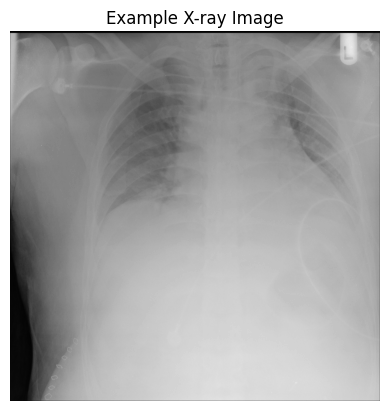

Features for example image: {'noise_var': 95.05253975683809, 'sharpness': 3.144683837890625, 'entropy': 7.0558786999386465, 'mean_intensity': 0.5439808368682861, 'std_intensity': 0.15215431153774261}


In [12]:

example_img_path = os.path.join(image_folder, image_files[0])
example_img = cv2.imread(example_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0


plt.imshow(example_img, cmap='gray')
plt.title('Example X-ray Image')
plt.axis('off')
plt.show()


example_features = feature_vector(example_img)
print("Features for example image:", example_features)

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress bar


image_folder = '/kaggle/input/sample/sample/images'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png') or f.endswith('.jpg')]
print(f"Total images found: {len(image_files)}")


def simulate_lower_dose(img, scale=0.8, add_noise_std=0.01):
    img2 = img * scale
    noise = np.random.normal(0.0, add_noise_std, img.shape)
    img2 += noise
    img2 = np.clip(img2, 0.0, 1.0)
    return img2

def estimate_noise_wavelet(img):
    lap = cv2.Laplacian((img*255).astype(np.uint8), cv2.CV_64F)
    return np.var(lap)

def estimate_sharpness(img):
    return np.mean(np.abs(cv2.Laplacian((img*255).astype(np.uint8), cv2.CV_64F)))

def image_entropy(img):
    hist, _ = np.histogram((img*255).astype(np.uint8), bins=256, range=(0,255))
    hist = hist / (hist.sum()+1e-12)
    hist = hist[hist>0]
    return -np.sum(hist * np.log2(hist))

def feature_vector(img):
    return {
        'noise_var': estimate_noise_wavelet(img),
        'sharpness': estimate_sharpness(img),
        'entropy': image_entropy(img),
        'mean_intensity': float(np.mean(img)),
        'std_intensity': float(np.std(img))
    }


all_features = []


scales = [1.0, 0.8, 0.6]
noise_stds = [0.005, 0.02, 0.04]

for img_name in tqdm(image_files, desc="Processing images"):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
    
    for scale, noise in zip(scales, noise_stds):
        sim_img = simulate_lower_dose(img, scale=scale, add_noise_std=noise)
        features = feature_vector(sim_img)
        features['image'] = img_name
        features['scale'] = scale
        features['noise_std'] = noise
        all_features.append(features)

df_features = pd.DataFrame(all_features)
csv_path = '/kaggle/working/nihr_features_full.csv'
df_features.to_csv(csv_path, index=False)
print(f"CSV for full dataset saved successfully at {csv_path}")

Total images found: 5606


Processing images: 100%|██████████| 5606/5606 [25:22<00:00,  3.68it/s]


CSV for full dataset saved successfully at /kaggle/working/nihr_features_full.csv


     noise_var  sharpness   entropy  mean_intensity  std_intensity  \
0   128.946312   5.954725  7.071649        0.543982       0.152216   
1   579.177549  18.704257  6.823825        0.435256       0.123151   
2  2087.355663  36.349570  6.593358        0.326636       0.098867   
3    61.793052   5.742437  7.469461        0.667077       0.213602   
4   539.571305  18.472152  7.253194        0.533670       0.171944   

              image  scale  noise_std  
0  00006199_010.png    1.0      0.005  
1  00006199_010.png    0.8      0.020  
2  00006199_010.png    0.6      0.040  
3  00003503_000.png    1.0      0.005  
4  00003503_000.png    0.8      0.020  
(16818, 8)


Epoch 0, Train Loss=0.5306


Epoch 5, Train Loss=0.0269


Epoch 10, Train Loss=0.0109


Epoch 15, Train Loss=0.0024


Epoch 20, Train Loss=0.0011


Epoch 25, Train Loss=0.0029


Epoch 30, Train Loss=0.0008


Epoch 35, Train Loss=0.0067


Epoch 40, Train Loss=0.0012


Epoch 45, Train Loss=0.0018


Epoch 50, Train Loss=0.0019


Epoch 55, Train Loss=0.0023


Epoch 60, Train Loss=0.0035


Epoch 65, Train Loss=0.0014


Epoch 70, Train Loss=0.0019


Epoch 75, Train Loss=0.0004


Epoch 80, Train Loss=0.0090


Epoch 85, Train Loss=0.0135


Epoch 90, Train Loss=0.0011


Epoch 95, Train Loss=0.0030


Test MSE: 0.0019266045


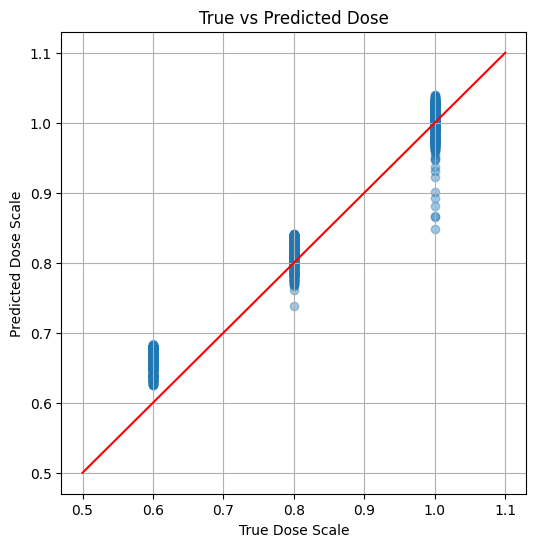

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# ----------------------------------------
# 1. Load dataset
# ----------------------------------------
df = pd.read_csv("/kaggle/working/nihr_features_full.csv")
print(df.head())
print(df.shape)

# ----------------------------------------
# 2. Prepare features & target
# target = dose proxy = scale (1.0, 0.8, 0.6)
# ----------------------------------------
feature_cols = ['noise_var','sharpness','entropy','mean_intensity','std_intensity']
X = df[feature_cols].values.astype(np.float32)
y = df['scale'].values.astype(np.float32)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# ----------------------------------------
# 3. Define MLP model
# ----------------------------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----------------------------------------
# 4. Train model
# ----------------------------------------
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        pred = model(xb).squeeze()
        loss = criterion(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Loss={train_loss:.4f}")

# ----------------------------------------
# 5. Evaluate
# ----------------------------------------
model.eval()
preds, trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb).squeeze()
        preds.extend(out.numpy())
        trues.extend(yb.numpy())

preds = np.array(preds)
trues = np.array(trues)

test_mse = np.mean((preds - trues)**2)
print("Test MSE:", test_mse)

# ----------------------------------------
# 6. Scatter Plot
# ----------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(trues, preds, alpha=0.4)
plt.plot([0.5,1.1], [0.5,1.1], color='red')
plt.xlabel("True Dose Scale")
plt.ylabel("Predicted Dose Scale")
plt.title("True vs Predicted Dose")
plt.grid()
plt.show()

In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Store true + predicted
        y_true_list.extend(target.cpu().numpy())
        y_pred_list.extend(output.cpu().numpy())

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true_list = np.array(y_true_list)
y_pred_list = np.array(y_pred_list)

r2 = r2_score(y_true_list, y_pred_list)
mae = mean_absolute_error(y_true_list, y_pred_list)
rmse = np.sqrt(mean_squared_error(y_true_list, y_pred_list))

print("R² Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

R² Score: 0.9282383553998212
MAE: 0.035724554
RMSE: 0.043893103


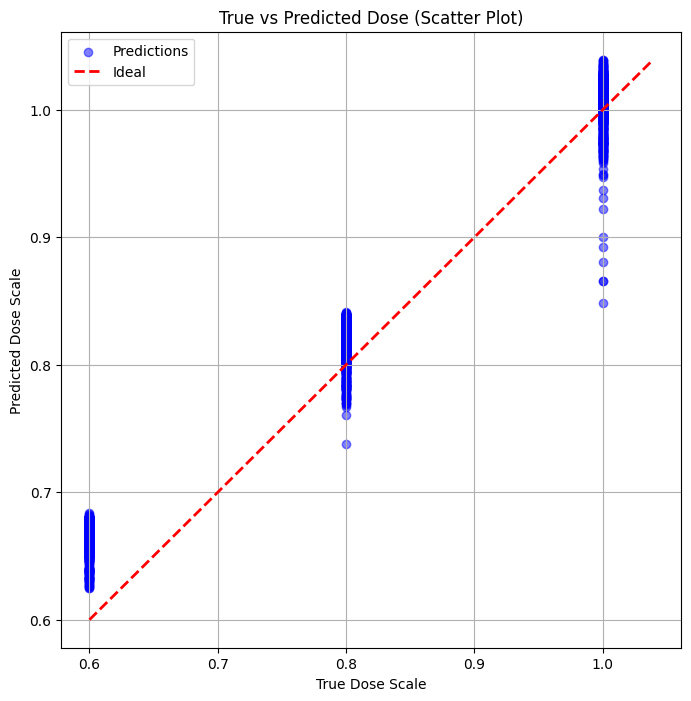

In [24]:
import matplotlib.pyplot as plt
import numpy as np


y_true_array = np.array(y_true_list)
y_pred_array = np.array(y_pred_list)


plt.figure(figsize=(8,8))
plt.scatter(y_true_array, y_pred_array, alpha=0.5, c='blue', label='Predictions')


min_val = min(y_true_array.min(), y_pred_array.min())
max_val = max(y_true_array.max(), y_pred_array.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

plt.xlabel("True Dose Scale")
plt.ylabel("Predicted Dose Scale")
plt.title("True vs Predicted Dose (Scatter Plot)")
plt.legend()
plt.grid(True)
plt.show()